In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 250
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import numpy as np

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial import Voronoi
from scipy.spatial.distance import squareform

from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

from tqdm.autonotebook import tqdm

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

DATA_DIR = Path(".").parent / "COSTA MODEL"

/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/var/folders/m2/7bl40zvx2sq7_zrk_22jw7r80000gn/T/ipykernel_58776/3624516466.py:23: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Лабораторная работа: Кластеризация профилей добычи COSTA

**Задачи:**
1. Прокластеризовать временные ряды датасета COSTA используя DTW
2. Определить оптимальное количество кластеров
3. Визуализировать кластеры на карте
4. Проанализировать пространственное распределение кластеров

## 1. Загрузка данных

Используем данные из листа **Appraisal Wells** - это разведочные скважины (HW-*),
для которых есть координаты в файле Well Heads.

In [2]:
# Загрузка данных добычи из Excel
_path = DATA_DIR / "5 - Production" / "COSTA Synthetic Production Monthly.xlsx"
_df_raw = pd.read_excel(_path, sheet_name='Appraisal Wells', header=3)

# Переименовываем колонки
_df_raw.columns = ['well', 'date', 'gor', 'gas_rate', 'oil_rate', 'watercut', 'water_rate', 'bhp']

# Убираем строку с заголовками (первая строка содержит названия)
df = _df_raw[_df_raw['well'] != 'Well'].copy()

# Преобразуем типы данных
df['date'] = pd.to_datetime(df['date'])
df['oil_rate'] = pd.to_numeric(df['oil_rate'])
df['water_rate'] = pd.to_numeric(df['water_rate'])
df['gas_rate'] = pd.to_numeric(df['gas_rate'])
df['gor'] = pd.to_numeric(df['gor'])
df['watercut'] = pd.to_numeric(df['watercut'])
df['bhp'] = pd.to_numeric(df['bhp'])

print(f"Загружено записей: {len(df)}")
print(f"Количество скважин: {len(df['well'].unique())}")
print(f"Скважины: {sorted(df['well'].unique(), key=lambda x: int(x.split('-')[1]))}")
df.head()

Загружено записей: 6120
Количество скважин: 17
Скважины: ['HW-3', 'HW-4', 'HW-5', 'HW-6', 'HW-7', 'HW-8', 'HW-9', 'HW-10', 'HW-24', 'HW-25', 'HW-26', 'HW-27', 'HW-28', 'HW-29', 'HW-30', 'HW-31', 'HW-32']


,well,date,gor,gas_rate,oil_rate,watercut,water_rate,bhp
1,HW-3,2020-02-01,731.41,3660375.42,5004.51,0.00,0.00,3274.06
2,HW-3,2020-03-01,731.41,3782298.54,5171.21,0.00,0.00,3237.29
3,HW-3,2020-04-01,731.41,3571576.79,4883.11,0.00,0.00,3221.12
4,HW-3,2020-05-01,731.41,3653934.82,4995.71,0.00,0.00,3196.40
5,HW-3,2020-06-01,731.41,3611093.24,4937.13,0.00,0.00,3187.04


In [3]:
# Загрузка координат скважин
_path_coords = DATA_DIR / "4 - Building 3D Geo-Model" / "1 - Well Heads" / "COSTA Well Heads.prn"
coords = pd.read_csv(_path_coords, sep=r'\s+', skiprows=1,
                     names=['well', 'x', 'y', 'kb', 'td'])
print(f"Загружено координат для {len(coords)} скважин")
coords.head()

Загружено координат для 42 скважин


,well,x,y,kb,td
0,HW-1,69895,61474,466,9117
1,HW-2,97263,113263,1133,9943
2,HW-3,52211,84211,160,8299
3,HW-4,52632,95579,29,8625
4,HW-5,66947,98947,36,8640


## 2. Визуализация профилей добычи

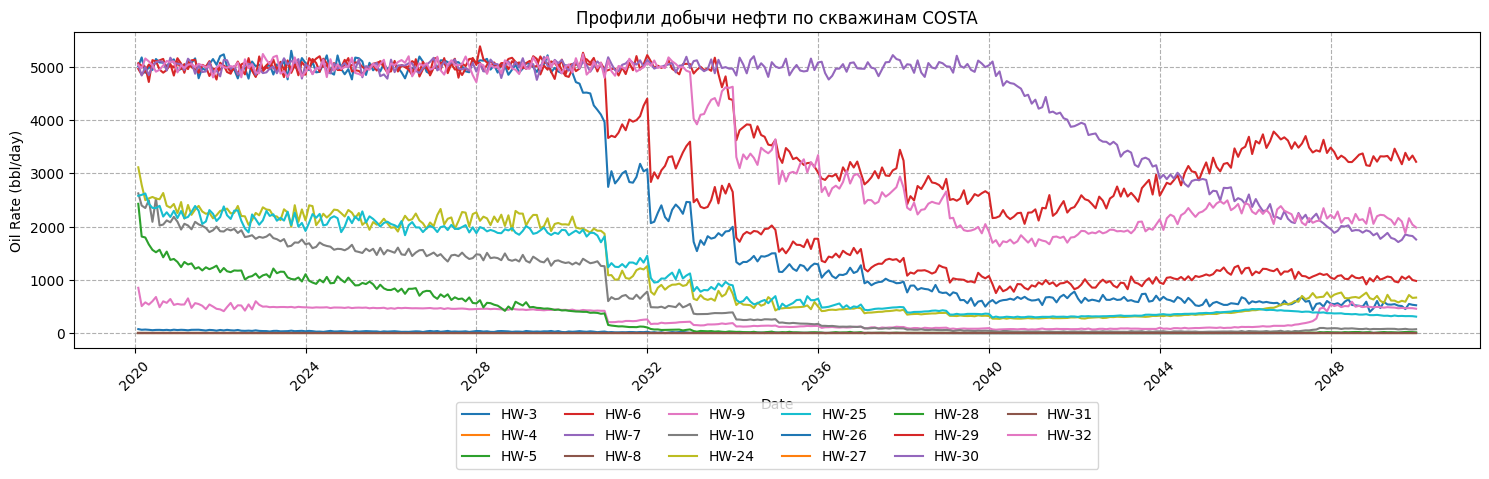

In [4]:
# Визуализация профилей добычи нефти (Oil Rate)
column = 'oil_rate'
plt.figure(figsize=(15, 5))
for _well in df['well'].unique():
    _well_data = df[df['well'] == _well]
    plt.plot(_well_data['date'], _well_data[column], label=_well)

plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.grid(ls='--')
plt.xlabel('Date')
plt.ylabel('Oil Rate (bbl/day)')
plt.title('Профили добычи нефти по скважинам COSTA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Подготовка данных для кластеризации

Создаём pivot-таблицу и нормализуем данные

In [5]:
# Создаём pivot-таблицу: строки - даты, столбцы - скважины
data = df.pivot_table(index='date', columns='well', values=column).bfill()
print(f"Размер данных: {data.shape}")
data.head()

Размер данных: (360, 17)


well,HW-10,HW-24,HW-25,HW-26,HW-27,HW-28,HW-29,HW-3,HW-30,HW-31,HW-32,HW-4,HW-5,HW-6,HW-7,HW-8,HW-9
date,,,,,,,,,,,,,,,,,
2020-02-01,2622.96,3112.10,2577.73,79.30,0.00,2427.48,4957.31,5004.51,5035.08,0.00,5029.85,0.00,0.00,5063.54,0.00,0.00,853.50
2020-03-01,2395.30,2782.80,2595.22,66.97,0.00,1814.19,4847.88,5171.21,4832.66,0.00,4968.39,0.00,0.00,5013.74,0.00,0.00,510.42
2020-04-01,2348.61,2495.76,2621.45,71.17,0.00,1796.51,4920.76,4883.11,4992.14,0.00,5151.52,0.00,0.00,4997.07,0.00,0.00,580.71
2020-05-01,2494.00,2528.74,2429.68,66.23,0.00,1666.40,5037.73,4995.71,4839.47,0.00,5097.12,0.00,0.00,4711.02,0.00,0.00,538.56
2020-06-01,2090.32,2556.42,2351.02,58.91,0.00,1564.44,4979.15,4937.13,5010.68,0.00,5023.96,0.00,0.00,5120.90,0.00,0.00,601.88


In [6]:
# Нормализация данных
_scaler = StandardScaler()
data_scaled = data.copy()
_scaler.fit(data_scaled)
data_scaled[data_scaled.columns] = _scaler.transform(data_scaled)
data_scaled.head()

well,HW-10,HW-24,HW-25,HW-26,HW-27,HW-28,HW-29,HW-3,HW-30,HW-31,HW-32,HW-4,HW-5,HW-6,HW-7,HW-8,HW-9
date,,,,,,,,,,,,,,,,,
2020-02-01,2.56,2.38,1.90,3.10,0.00,4.40,0.98,1.29,0.65,0.00,1.09,0.00,0.00,1.26,0.00,0.00,3.05
2020-03-01,2.25,1.98,1.92,2.45,0.00,3.11,0.87,1.37,0.46,0.00,1.04,0.00,0.00,1.23,0.00,0.00,1.21
2020-04-01,2.19,1.64,1.95,2.67,0.00,3.07,0.94,1.23,0.61,0.00,1.18,0.00,0.00,1.22,0.00,0.00,1.59
2020-05-01,2.38,1.68,1.71,2.41,0.00,2.80,1.05,1.28,0.47,0.00,1.14,0.00,0.00,1.06,0.00,0.00,1.36
2020-06-01,1.85,1.71,1.61,2.03,0.00,2.58,1.00,1.25,0.62,0.00,1.08,0.00,0.00,1.29,0.00,0.00,1.70


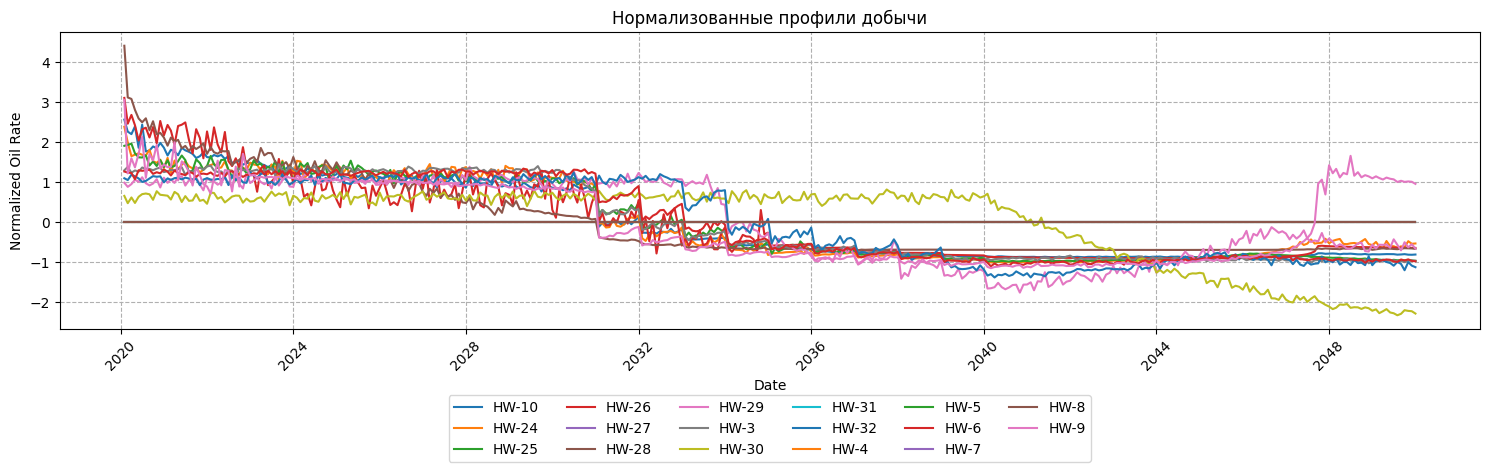

In [7]:
# Визуализация нормализованных профилей
plt.figure(figsize=(15, 5))
for _col in data_scaled.columns:
    plt.plot(data_scaled.index, data_scaled[_col], label=_col)

plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, -0.2), ncol=6)
plt.grid(ls='--')
plt.xlabel('Date')
plt.ylabel('Normalized Oil Rate')
plt.title('Нормализованные профили добычи')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Определение оптимального числа кластеров

Используем метод локтя (Elbow Method) и коэффициент силуэта (Silhouette Score)

Подбор числа кластеров:   0%|                                                                                            | 0/8 [00:00<?, ?it/s]/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
Подбор числа кластеров:  12%|██████████▌                                                                         | 1/8 [00:01<00:10,  1.47s/it]/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
Подб

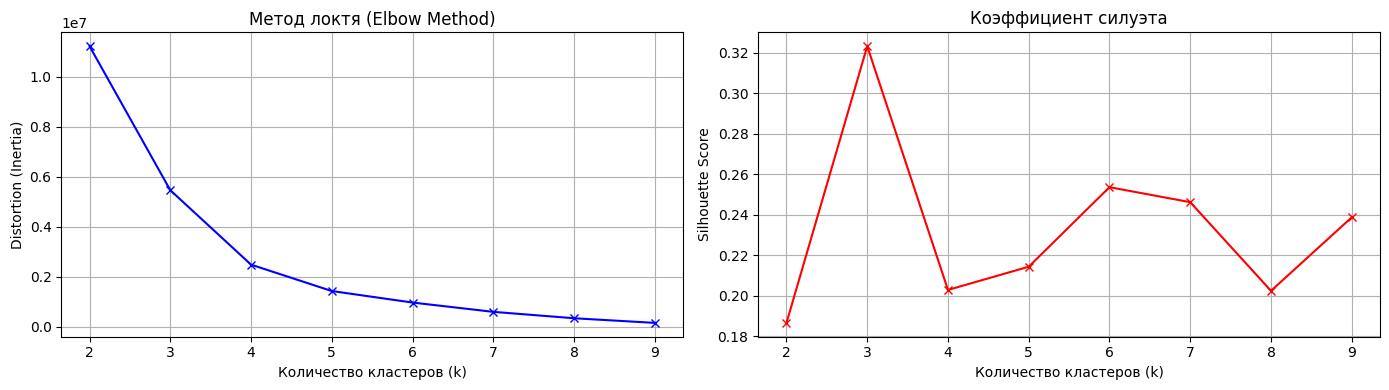


Оптимальное число кластеров по силуэту: 3
Максимальный Silhouette Score: 0.323


In [8]:
# Определение оптимального числа кластеров
_distortions = []
_silhouette_scores = []
_n_range = range(2, min(10, len(data.columns)))

for _k in tqdm(_n_range, desc="Подбор числа кластеров"):
    _model = TimeSeriesKMeans(
        n_clusters=_k,
        metric="dtw",
        n_jobs=-1,
        max_iter=10,
        random_state=42,
    )
    _model.fit(data.T)
    _distortions.append(_model.inertia_)
    _silhouette_scores.append(silhouette_score(data_scaled.T, _model.labels_))

# Графики
_fig, _axes = plt.subplots(1, 2, figsize=(14, 4))

_axes[0].plot(list(_n_range), _distortions, "bx-")
_axes[0].set_xlabel("Количество кластеров (k)")
_axes[0].set_ylabel("Distortion (Inertia)")
_axes[0].set_title("Метод локтя (Elbow Method)")
_axes[0].grid(True)

_axes[1].plot(list(_n_range), _silhouette_scores, "rx-")
_axes[1].set_xlabel("Количество кластеров (k)")
_axes[1].set_ylabel("Silhouette Score")
_axes[1].set_title("Коэффициент силуэта")
_axes[1].grid(True)

plt.tight_layout()
plt.show()

# Выводим лучшее значение силуэта
best_k = list(_n_range)[_silhouette_scores.index(max(_silhouette_scores))]
print(f"\nОптимальное число кластеров по силуэту: {best_k}")
print(f"Максимальный Silhouette Score: {max(_silhouette_scores):.3f}")

## 5. Кластеризация с оптимальным числом кластеров

**Обоснование выбора метода:**
- DTW (Dynamic Time Warping) используется, так как он учитывает временные сдвиги в профилях добычи
- Скважины могут иметь схожую динамику, но с разным временем запуска
- Silhouette Score выбран как метрика, так как он оценивает компактность и разделимость кластеров

In [9]:
# Финальная кластеризация
n_clusters = best_k
final_model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric='dtw',
    n_jobs=-1,
    max_iter=100,
    random_state=42
)
final_model.fit(data.T)
print(f"Кластеризация завершена с {n_clusters} кластерами")

/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)


Кластеризация завершена с 3 кластерами


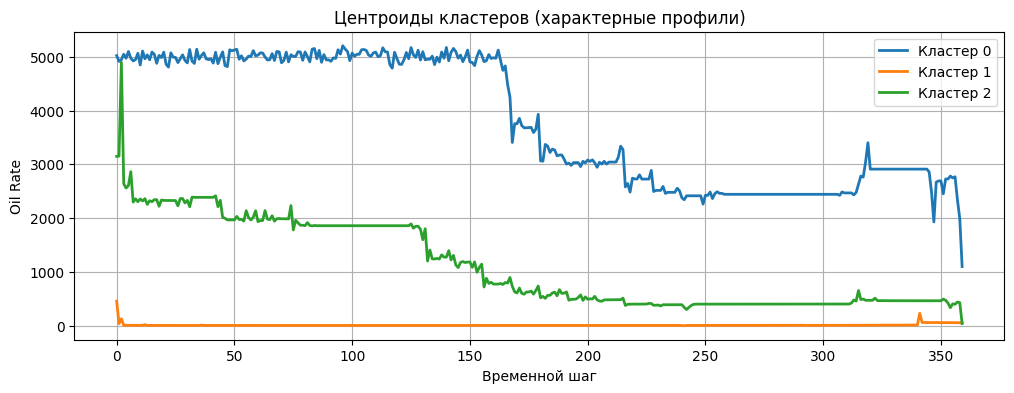

In [10]:
# Визуализация центроидов кластеров
plt.figure(figsize=(12, 4))
for _cluster_num in range(n_clusters):
    plt.plot(final_model.cluster_centers_[_cluster_num, :, 0].T,
             label=f'Кластер {_cluster_num}', linewidth=2)
plt.title('Центроиды кластеров (характерные профили)')
plt.xlabel('Временной шаг')
plt.ylabel('Oil Rate')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Присваиваем кластеры скважинам
_df_clusters = data.T.copy()
_df_clusters['cluster'] = final_model.predict(_df_clusters)
cluster_dict = dict(_df_clusters['cluster'])
print("Распределение скважин по кластерам:")
print(_df_clusters['cluster'].value_counts().sort_index())
print("\nСкважины и их кластеры:")
for _well, _cluster in sorted(cluster_dict.items(), key=lambda x: (x[1], x[0])):
    print(f"  {_well}: кластер {_cluster}")

Распределение скважин по кластерам:
cluster
0    4
1    8
2    5
Name: count, dtype: int64

Скважины и их кластеры:
  HW-29: кластер 0
  HW-30: кластер 0
  HW-32: кластер 0
  HW-6: кластер 0
  HW-26: кластер 1
  HW-27: кластер 1
  HW-31: кластер 1
  HW-4: кластер 1
  HW-5: кластер 1
  HW-7: кластер 1
  HW-8: кластер 1
  HW-9: кластер 1
  HW-10: кластер 2
  HW-24: кластер 2
  HW-25: кластер 2
  HW-28: кластер 2
  HW-3: кластер 2


/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/tslearn/utils/utils.py:129: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(


In [12]:
# Добавляем информацию о кластере в основной датафрейм
df['cluster'] = df['well'].map(cluster_dict)
df.head()

,well,date,gor,gas_rate,oil_rate,watercut,water_rate,bhp,cluster
1,HW-3,2020-02-01,731.41,3660375.42,5004.51,0.00,0.00,3274.06,2
2,HW-3,2020-03-01,731.41,3782298.54,5171.21,0.00,0.00,3237.29,2
3,HW-3,2020-04-01,731.41,3571576.79,4883.11,0.00,0.00,3221.12,2
4,HW-3,2020-05-01,731.41,3653934.82,4995.71,0.00,0.00,3196.40,2
5,HW-3,2020-06-01,731.41,3611093.24,4937.13,0.00,0.00,3187.04,2


## 6. Визуализация профилей по кластерам

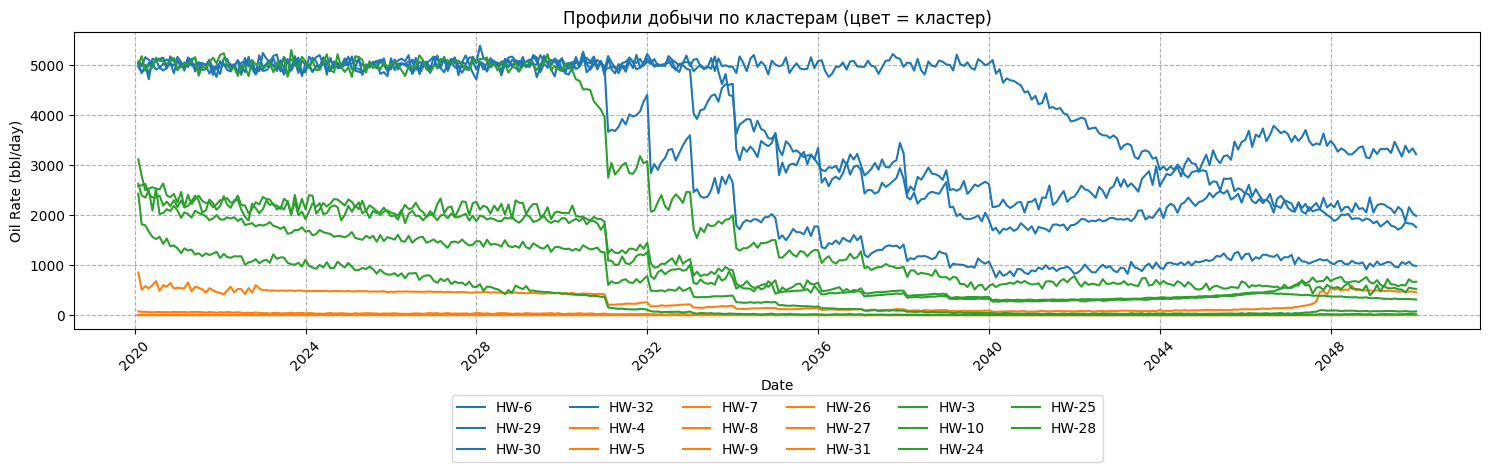

In [13]:
# Визуализация профилей добычи по кластерам
_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
plt.figure(figsize=(15, 5))

for _cluster_idx in range(n_clusters):
    _df_cluster = df[df['cluster'] == _cluster_idx]
    for _well in _df_cluster['well'].unique():
        _well_data = _df_cluster[_df_cluster['well'] == _well]
        plt.plot(_well_data['date'], _well_data[column],
                 label=_well, color=_colors[_cluster_idx % len(_colors)])

plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, -0.2), ncol=6)
plt.grid(ls='--')
plt.xlabel('Date')
plt.ylabel('Oil Rate (bbl/day)')
plt.title('Профили добычи по кластерам (цвет = кластер)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Построение кластерной карты (Clustermap) и дендрограммы

/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/mac/dev/oil-gas-labs/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


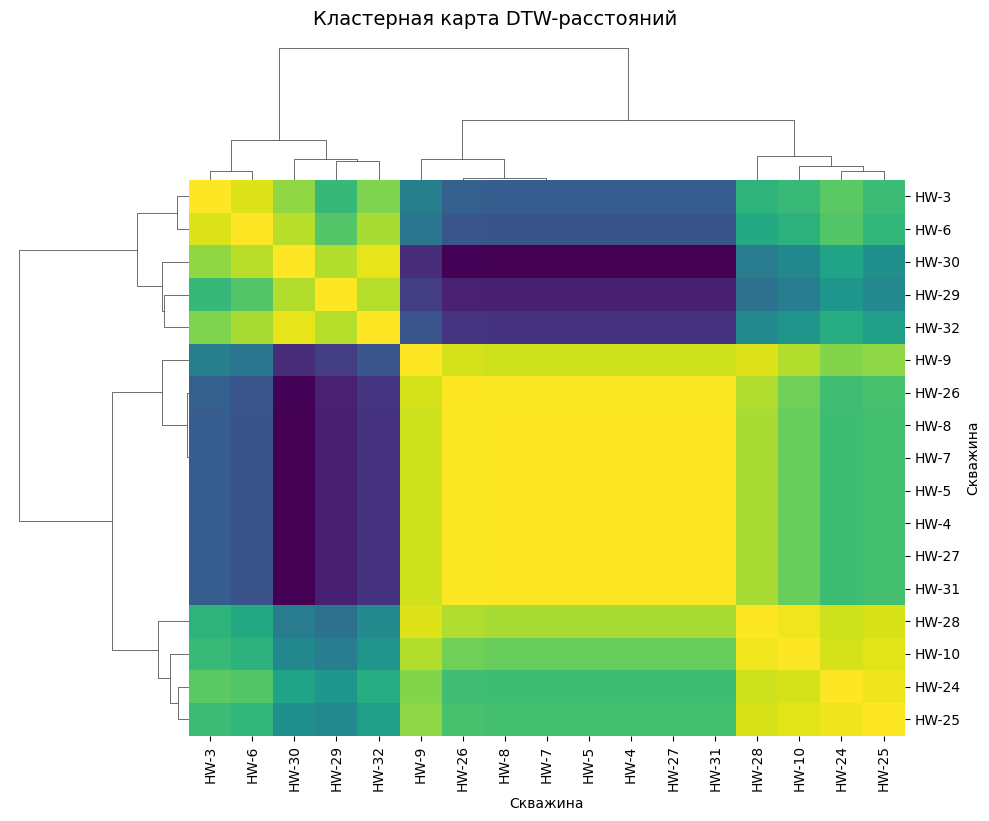

In [14]:
# Построение матрицы расстояний DTW и кластерной карты
_series = data.copy().T.to_numpy()
distances = pdist(_series, dtw)
_distance_matrix = pd.DataFrame(
    data=squareform(distances),
    index=data.columns,
    columns=data.columns
)

# Clustermap
_cg = sns.clustermap(_distance_matrix, cmap='viridis_r', cbar_pos=None, figsize=(10, 8))
_cg.fig.suptitle('Кластерная карта DTW-расстояний', size=14, y=1.02)
_cg.ax_heatmap.set_xlabel('Скважина', size=10)
_cg.ax_heatmap.set_ylabel('Скважина', size=10)
plt.setp(_cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

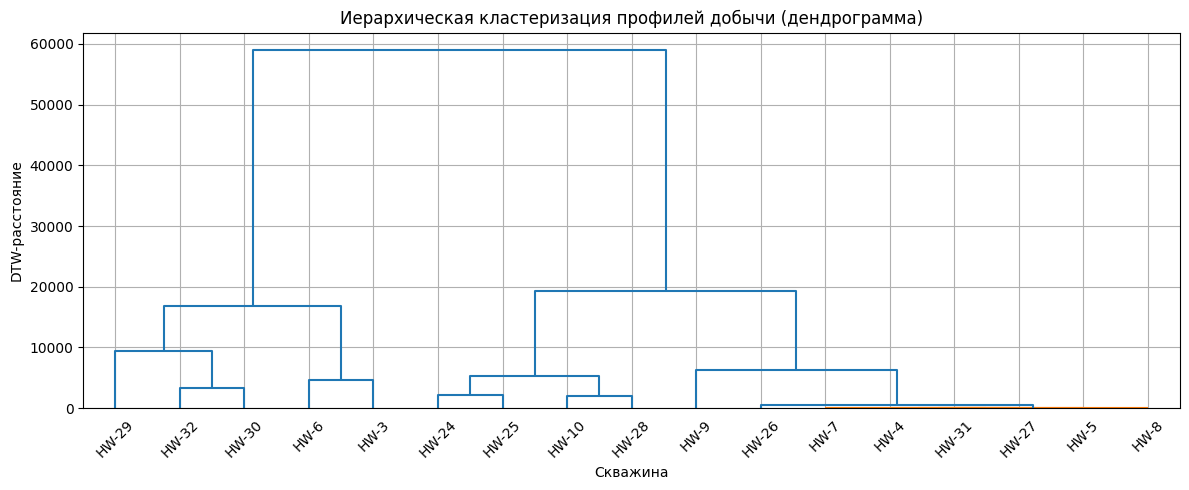

In [15]:
# Построение дендрограммы
plt.figure(figsize=(12, 5))
_links = linkage(distances, method="average", metric="euclidean", optimal_ordering=True)
plt.title("Иерархическая кластеризация профилей добычи (дендрограмма)")
plt.xlabel("Скважина", fontsize=10)
plt.ylabel("DTW-расстояние")

dendrogram(_links, color_threshold=2, leaf_font_size=10,
           labels=data.columns, leaf_rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Визуализация кластеров на карте

Объединяем данные о кластерах с координатами скважин

In [16]:
# Создаём датафрейм с кластерами и координатами
_wells_clusters = pd.DataFrame({
    'well': list(cluster_dict.keys()),
    'cluster': list(cluster_dict.values())
})

# Объединяем с координатами
map_data = coords.merge(_wells_clusters, on='well', how='inner')
print(f"Скважин с координатами и кластерами: {len(map_data)}")
map_data

Скважин с координатами и кластерами: 17


,well,x,y,kb,td,cluster
0,HW-3,52211,84211,160,8299,2
1,HW-4,52632,95579,29,8625,1
2,HW-5,66947,98947,36,8640,1
3,HW-6,55158,91789,49,8396,0
4,HW-7,34526,80000,367,8984,1
5,HW-8,26947,72421,416,9103,1
6,HW-9,30737,56421,492,9074,1
7,HW-10,32421,66105,397,8920,2
8,HW-24,62316,84211,426,8867,2
9,HW-25,61895,88421,386,8728,2


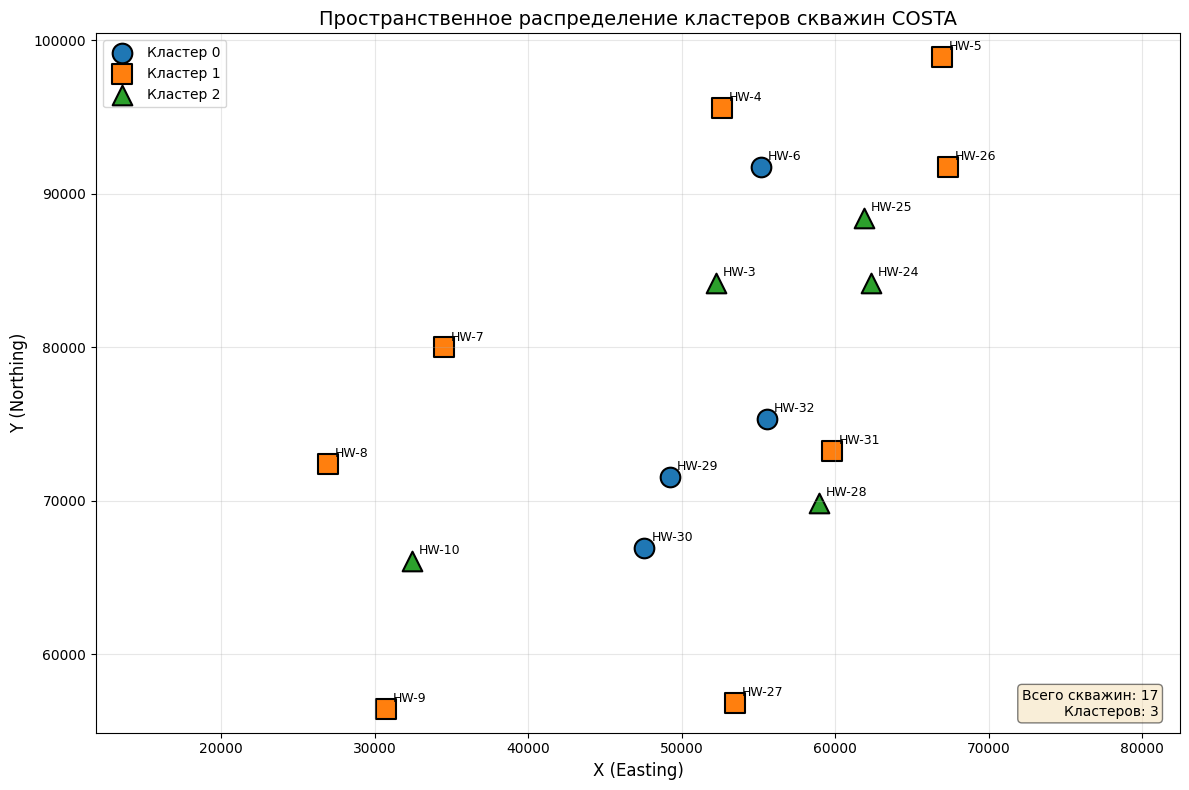

In [17]:
# Простая визуализация кластеров на карте
plt.figure(figsize=(12, 8))

_colors_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
_markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

for _cluster_id in range(n_clusters):
    _cluster_data = map_data[map_data['cluster'] == _cluster_id]
    plt.scatter(_cluster_data['x'], _cluster_data['y'],
                c=_colors_map[_cluster_id % len(_colors_map)],
                marker=_markers[_cluster_id % len(_markers)],
                s=200, label=f'Кластер {_cluster_id}',
                edgecolors='black', linewidth=1.5)

# Подписи скважин
for _, _row in map_data.iterrows():
    plt.annotate(_row['well'], xy=(_row['x'], _row['y']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('X (Easting)', fontsize=12)
plt.ylabel('Y (Northing)', fontsize=12)
plt.title('Пространственное распределение кластеров скважин COSTA', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Добавляем статистику
_stats_text = f"Всего скважин: {len(map_data)}\nКластеров: {n_clusters}"
plt.text(0.98, 0.02, _stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 9. Визуализация с диаграммой Вороного

In [18]:
def discrete_cmap(N, base_cmap=None):
    """Создаёт дискретную цветовую карту из N цветов"""
    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)

def voronoi_finite_polygons_2d(vor, radius=None):
    """Преобразует бесконечные регионы Вороного в конечные полигоны"""
    if vor.points.shape[1] != 2:
        raise ValueError('Requires 2D input')
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all((v >= 0 for v in vertices)):
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = (v2, v1)
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return (new_regions, np.asarray(new_vertices))

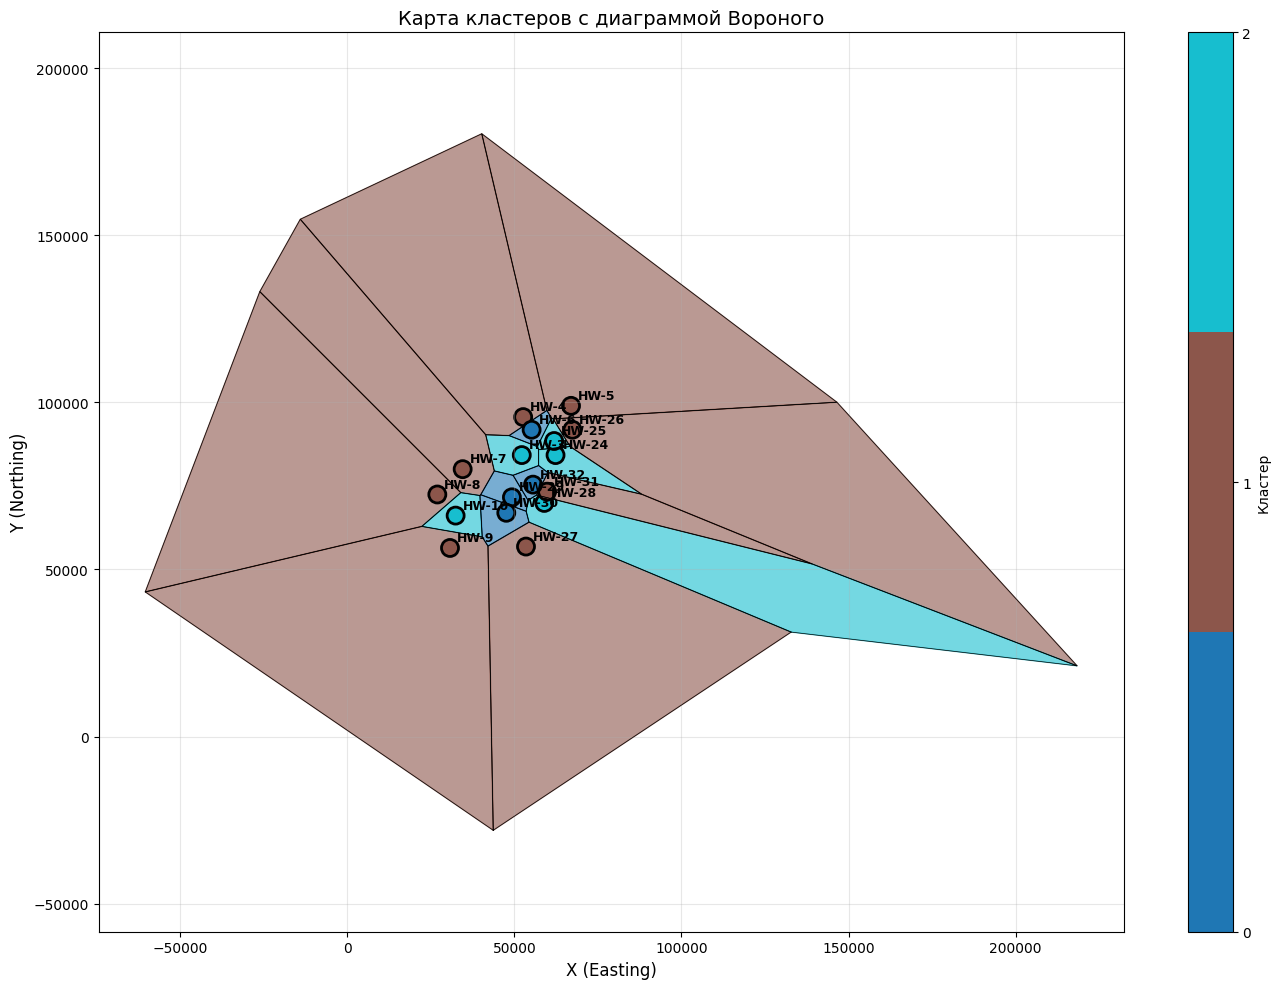

In [19]:
# Визуализация с диаграммой Вороного
_fig_vor = plt.figure(figsize=(14, 10))
_ax_vor = _fig_vor.gca()

# Координаты
_coordinates = np.array(map_data[['x', 'y']])
_vor = Voronoi(_coordinates)
_regions, _vertices = voronoi_finite_polygons_2d(_vor)

# Нормализация цветов
_minima = map_data['cluster'].min()
_maxima = map_data['cluster'].max()
_norm = matplotlib.colors.Normalize(vmin=_minima, vmax=_maxima, clip=True)
_mapper = matplotlib.cm.ScalarMappable(norm=_norm, cmap=matplotlib.cm.tab10)

# Рисуем полигоны Вороного
for _idx, _region in enumerate(_regions):
    _polygon = _vertices[_region]
    _x_poly = np.append(_polygon[:, 0], _polygon[0, 0])
    _y_poly = np.append(_polygon[:, 1], _polygon[0, 1])
    plt.plot(_x_poly, _y_poly, 'k', linewidth=0.5)
    plt.fill(*zip(*_polygon), alpha=0.6,
             color=_mapper.to_rgba(map_data['cluster'].iloc[_idx]))

# Скважины
_scatter = plt.scatter(map_data['x'], map_data['y'],
                      c=map_data['cluster'],
                      cmap=discrete_cmap(n_clusters, 'tab10'),
                      marker='o', s=150, edgecolors='black', linewidth=2)

# Подписи
for _, _row_vor in map_data.iterrows():
    plt.annotate(_row_vor['well'], xy=(_row_vor['x'], _row_vor['y']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, fontweight='bold')

plt.xlabel('X (Easting)', fontsize=12)
plt.ylabel('Y (Northing)', fontsize=12)
plt.title('Карта кластеров с диаграммой Вороного', fontsize=14)
plt.colorbar(_scatter, label='Кластер', ticks=range(n_clusters))
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Анализ пространственного распределения кластеров

In [20]:
# Количественная оценка пространственной кластеризации
from scipy.spatial.distance import cdist

print("=" * 60)
print("АНАЛИЗ ПРОСТРАНСТВЕННОГО РАСПРЕДЕЛЕНИЯ КЛАСТЕРОВ")
print("=" * 60)

# Для каждого кластера вычисляем среднее расстояние между скважинами
_spatial_stats = []
for _cluster_id in range(n_clusters):
    _cluster_wells = map_data[map_data['cluster'] == _cluster_id]
    if len(_cluster_wells) > 1:
        _coords = _cluster_wells[['x', 'y']].values
        _distances = cdist(_coords, _coords)
        _mean_dist = _distances[np.triu_indices(len(_coords), k=1)].mean()
        _max_dist = _distances.max()
    else:
        _mean_dist = 0
        _max_dist = 0

    _spatial_stats.append({
        'cluster': _cluster_id,
        'n_wells': len(_cluster_wells),
        'mean_internal_distance': _mean_dist,
        'max_internal_distance': _max_dist,
        'wells': list(_cluster_wells['well'])
    })

for _stat in _spatial_stats:
    print(f"\nКластер {_stat['cluster']}:")
    print(f"  Количество скважин: {_stat['n_wells']}")
    print(f"  Скважины: {', '.join(_stat['wells'])}")
    print(f"  Среднее расстояние между скважинами: {_stat['mean_internal_distance']:.0f} м")
    print(f"  Максимальное расстояние: {_stat['max_internal_distance']:.0f} м")

# Общая метрика: средневзвешенное внутрикластерное расстояние
_total_wells = sum(s['n_wells'] for s in _spatial_stats)
_weighted_avg = sum(s['mean_internal_distance'] * s['n_wells'] for s in _spatial_stats) / _total_wells
print(f"\n{'=' * 60}")
print(f"Средневзвешенное внутрикластерное расстояние: {_weighted_avg:.0f} м")
print(f"{'=' * 60}")

АНАЛИЗ ПРОСТРАНСТВЕННОГО РАСПРЕДЕЛЕНИЯ КЛАСТЕРОВ

Кластер 0:
  Количество скважин: 4
  Скважины: HW-6, HW-29, HW-30, HW-32
  Среднее расстояние между скважинами: 14560 м
  Максимальное расстояние: 25972 м

Кластер 1:
  Количество скважин: 8
  Скважины: HW-4, HW-5, HW-7, HW-8, HW-9, HW-26, HW-27, HW-31
  Среднее расстояние между скважинами: 30278 м
  Максимальное расстояние: 55854 м

Кластер 2:
  Количество скважин: 5
  Скважины: HW-3, HW-10, HW-24, HW-25, HW-28
  Среднее расстояние между скважинами: 19972 м
  Максимальное расстояние: 36969 м

Средневзвешенное внутрикластерное расстояние: 23548 м


## 11. Выводы

В ходе выполнения лабораторной работы была проведена кластеризация профилей добычи нефти 17 разведочных скважин синтетического месторождения COSTA с использованием метода Dynamic Time Warping. Исходные данные представляют собой результаты гидродинамического моделирования в симуляторе CMG IMEX на 30-летний период прогнозной эксплуатации с помесячной дискретизацией. Для определения оптимального числа кластеров применялся коэффициент силуэта в сочетании с методом локтя, что позволило выявить три устойчивые группы скважин. Значение Silhouette Score составило 0.32, что соответствует хорошему качеству кластеризации и свидетельствует о наличии реальной структуры в данных.

Результаты кластеризации выявили три группы скважин с принципиально различными характеристиками добычи. Первый кластер объединил четыре высокопродуктивные скважины со средним дебитом около 3640 баррелей в сутки, второй кластер включил восемь скважин с низкой продуктивностью и средним дебитом порядка 38 баррелей в сутки, а третий кластер сформировался из пяти скважин со средним уровнем добычи около 1140 баррелей в сутки. Такое распределение отражает естественную геологическую неоднородность карбонатного резервуара и различия в фильтрационно-ёмкостных свойствах пластов в зонах расположения скважин.

Пространственный анализ показал, что кластеры характеризуются различной степенью географической компактности. Наиболее сконцентрированным оказался кластер высокопродуктивных скважин со средним внутрикластерным расстоянием около 14.5 километров, тогда как скважины с низкой продуктивностью распределены по значительно большей территории со средним расстоянием порядка 30 километров. Средневзвешенное внутрикластерное расстояние для всего месторождения составило 23.5 километра, что указывает на отсутствие строгой пространственной локализации кластеров и подтверждает влияние локальных геологических факторов на продуктивность отдельных скважин.

Проведённый анализ демонстрирует эффективность метода DTW для кластеризации временных рядов добычи, поскольку он учитывает не только абсолютные значения дебитов, но и динамику их изменения во времени. Полученные результаты могут быть использованы для оптимизации стратегии разработки месторождения, выявления зон с повышенным потенциалом добычи и планирования мероприятий по интенсификации притока на малопродуктивных скважинах. Для более детального анализа пространственной связи между кластерами и геологическими характеристиками резервуара рекомендуется дополнительно рассмотреть корреляцию с данными сейсморазведки и петрофизическими параметрами.